In [4]:
# Import Statments:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Reading Curated AMP.txt file from https://aps.unmc.edu/:
with open('AMP.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Tokenizing Amino Acids:
chars = sorted(list(set(text)))
vocab_size = len(chars)

itos = {ch:i for ch,i in enumerate(chars)}
stoi = {i:ch for ch,i in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[n] for n in l])

data = torch.tensor(encode(text), dtype=torch.long)

# Creating Training/Validation Split:
n = int(0.9 * len(data))

train_data = data[:n]
val_data = data[n:]

# Creating Training Batches:
block_size = 8
batch_size = 4

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    xb = torch.stack([data[i:i+block_size] for i in ix])
    yb = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return xb, yb

xb, yb = get_batch('train')
xb, yb

(tensor([[ 7,  7,  8,  6,  7,  1, 10,  3],
         [ 6,  6, 17, 16, 16,  5,  6,  6],
         [10,  1,  4,  9, 10,  9, 13,  0],
         [11,  3, 17, 18,  9, 12,  1,  1]]),
 tensor([[ 7,  8,  6,  7,  1, 10,  3,  1],
         [ 6, 17, 16, 16,  5,  6,  6,  9],
         [ 1,  4,  9, 10,  9, 13,  0,  6],
         [ 3, 17, 18,  9, 12,  1,  1,  9]]))

In [5]:
# Creating Hyperparameters:
n_embd = 384
head_size = 16
n_layer = 6
n_head = 6
batch_size = 64
block_size = 256
dropout = 0.2

# Single Head of Attention:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()

        # K,Q,V Matrices:
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)

        # Buffer Matrix and Dropout Layer:
        self.register_buffer('tril', torch.tril(torch.ones([block_size, block_size])))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x)
        q = self.query(x)

        # Determining Affinities with Weighted Sum:
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Adjusting Embedding With Value Matrix:
        v = self.value(x)
        out = wei @ v
        return out

# Parralelization of Attention Heads:
class MultiHeadedAttention(nn.Module):

    def __init__(self, head_size, n_head):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])

        # Projection and Dropout Layers:
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

# Multi-Layer Perceptron:
class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()

        # Linear Layers:
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd * 4),
            nn.ReLU(),
            nn.Linear(n_embd * 4, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# Self-Attention/MLP Block:
class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head

        # Self-Attention/MLP:
        self.sa = MultiHeadedAttention(head_size, n_head)
        self.ffwd = FeedForward(n_embd)

        # Layer Normalization:
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    # Residual Blocks:
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# AMP Transformer Model:
class AMPTransformer(nn.Module):

    def __init__(self):
        super().__init__()

        # Token and Positional Embedding Tables:
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Block Layers:
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])

        # Layer Normalization and Unembedding:
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape

        # Embedding:
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = tok_emb + pos_emb

        # Creating Logits after Forward Pass:
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # Determining Loss via Cross Entropy
        if targets == None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx):

        # Generate New Data Until End Token:
        while True:
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_new = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_new], dim=1)
            if idx_new == 0:
                break

        return idx
        
# Initializing Model
m = AMPTransformer()

# Creating Optimizer:
optimizer = torch.optim.Adam(m.parameters(), lr=3e-4)

In [6]:
# Creating Training Loop:
for steps in range(500):

    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if steps % 50 == 0:
        print(f'Loss: {loss:.4f}')

print(f'Total Loss: {loss:.4f}')

Loss: 3.2677
Loss: 2.7822
Loss: 2.8040
Loss: 2.8164
Loss: 2.7339
Loss: 2.6758
Loss: 2.6877
Loss: 2.6854
Loss: 2.5892
Loss: 2.5821
Total Loss: 2.6065


In [7]:
# Generating Novel AMP Sequences:
sequences = []

def generate(n, min_length):
    for _ in range(n):
        new_acid_size = 0
        while new_acid_size < min_length:
            idx = torch.zeros([1, 1], dtype=torch.long)
            new_acid = decode(m.generate(idx)[0].tolist())
            new_acid_size = len(new_acid)
        print(new_acid)
        sequences.append(new_acid)

generate(10, 10)


KAIGPKLWLLGIPQIPERGANFAVNR


WGRRIVTTRLGSLLTGVKLSGTFISASSSGSSADFPLTAKIY


ALYWKKLVWGKINGLALCTGN


SGRLLGGLACPKSGPGNLALGLGLRHCGVCGHGG


KQIRRSKGAKKYKEFLYFKKEKDFAGYFGQ


FFAKPVGDDDLCITKVKNLGVGLDNAITKCYQCERQQV


ASGVAGLLGKGPGGLLQKHQ


FIGINEVGAGAARVLDVACRTVYFEKRCTRVRCL


AVHQAGLGNCVLFLEHSGVCAGHSKDVGGNSCQTHC


TIVTSKTRGSGEGKTLALLEKQGNLATLRAAYQTTALQAAKTAIGGNACKATTLSATAR



In [8]:
import py3Dmol
import requests

sequence = sequences[0]

# Visualizing Sequence via py3Dmol and esmatlas
url = "https://api.esmatlas.com/foldSequence/v1/pdb/"
response = requests.post(url, data=sequence)
pdb_str = response.text

# Removed for GitHub Visualization:
# view = py3Dmol.view(width=1000, height=500)
# view.addModel(pdb_str, "pdb")
# view.setStyle({"cartoon": {"color": "spectrum"}})
# view.zoomTo()
# view.show()

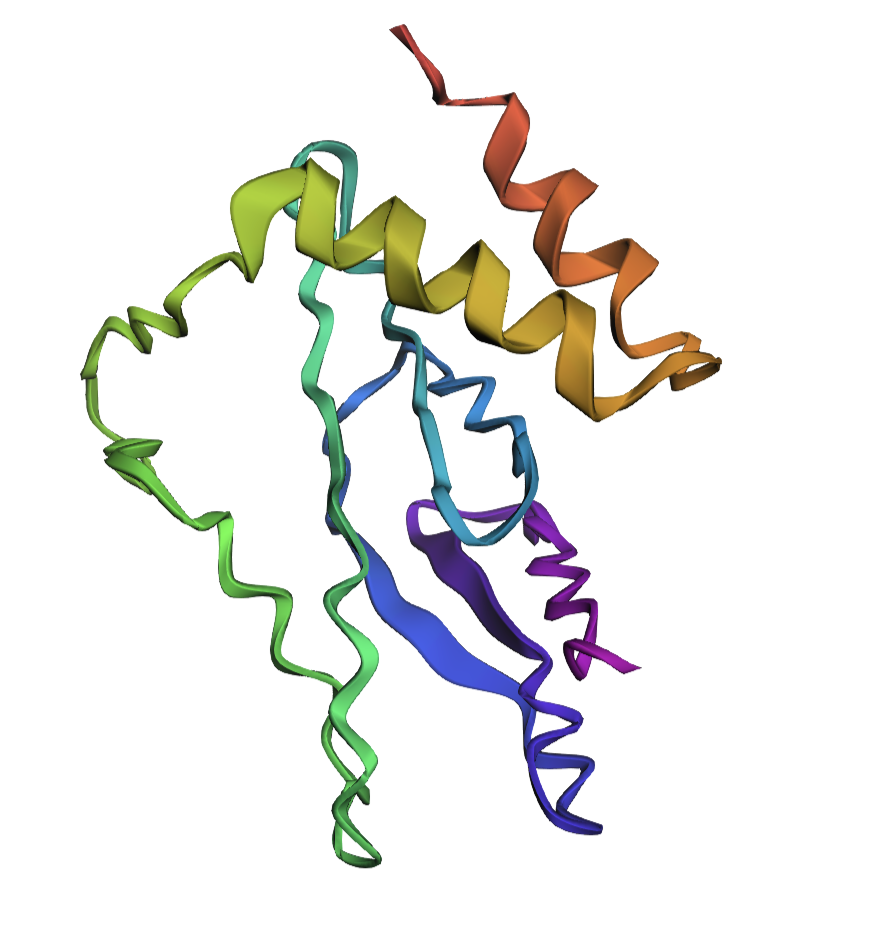

In [44]:
# Testing Validation Loss:
for steps in range(500):

    xb, yb = get_batch('val')
    logits, loss = m(xb, yb)
    with torch.inference_mode():
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if steps % 50 == 0:
            print(f'Loss: {loss:.4f}')

print(f'Total Loss: {loss:.4f}')

Loss: 3.6413
Loss: 1.3096
Loss: 0.5191
Loss: 0.2935
Loss: 0.2060
Loss: 0.1875
Loss: 0.1536
Loss: 0.1454
Loss: 0.1255
Loss: 0.1171
Total Loss: 0.1069
